## predicting health coverage in the US

This project will call data from the American Community Survey Public Use MicroSample (PUMS) API. The most recent survey publicly availble at this API is from 2019. (Note data from 2020 are available to download in csv files).

This project uses the Census Bureau Data API but is not endorsed or certified by the Census Bureau.

1. American Community Survey (ACS) (census.gov).
https://www.census.gov/programs-surveys/acs/
2. American Community Survey Data via API (census.gov).
https://www.census.gov/programs-surveys/acs/data/data-via-api.html

The goal of this project is to predict whether an individual has private health coverage (or not) based on demographic data in the PUMS. 

In [1]:
import os
import glob
import pandas as pd
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import dotenv_values
import utils

There are hundreds of variables in the PUMS dataset. Load in the variable names (code) and their descriptions (label) from the API.

In [2]:
env_vars = dotenv_values()
for key,value in env_vars.items():
    if key.__contains__('API_KEY'):
        API_KEY = value
_,_,_,nsamples = utils.getVars()
codedict,code = utils.getCodeDictionary()

Load info on the codes for each state + DC that we need for our api calls

In [3]:
stateinfo = pd.read_csv('https://www2.census.gov/programs-surveys/acs/tech_docs/pums/top_coded_values/2019_pums_top_and_bottom_coded_values.csv')
stateinfo = stateinfo.loc[:, stateinfo.columns.isin(['BST','STATE'])]
stateinfo = stateinfo[stateinfo.STATE != 'PR']

When calling the Census API, a maximum of 50 variables can be requested at one time. The data are also easily accessed state-by-state. The PUMS represents ~1% of the population. If we want to use data from all states, we could start by subsampling from availbable records. Set the number of samples (nsamples) in getCensusDataByState().

One approach is to request data from a list of variables for a specific state in one call. The function callCensusAPI() below is meant to return a dataframe with variables in 'select_codes' from one state ('stateid'). A second function, getCensusDataByState() is meant to request data for all variables for one state in multiple calls and merge that data into one single dataframe for that state.

With the functions above, we can loop through our states of interest and save a dataframe for each if it does not exist locally yet.

In [4]:
datadir = os.path.join(os.getcwd(),"raw_data")
if os.path.isdir(datadir) == False:
    os.mkdir(datadir)
interimdatadir = os.path.join(os.getcwd(),"interim_data")
if os.path.isdir(interimdatadir) == False:
    os.mkdir(interimdatadir)
figdir = os.path.join(os.getcwd(),"plots")
if os.path.isdir(figdir) == False:
    os.mkdir(figdir)
modeldir = os.path.join(os.getcwd(),"models")
if os.path.isdir(modeldir) == False:
    os.mkdir(modeldir)

Call API for states in loop and save csv locally if it doesn't exist yet

In [5]:
for state in stateinfo['BST']:
    state_id  =  f"{state:02}"
    fname = os.path.join(datadir,'state' + state_id + '_subsample' + str(nsamples) + '.csv')
    if os.path.exists(fname) == False:
        df,totalTime = utils.getCensusDataByState(state_id,API_KEY)
        df.to_csv(fname)
        print('state' + state_id + ': ' + str(totalTime))
        del df
        del fname
        del state_id

Load saved csv files.

In [6]:
filenames = glob.glob(os.path.join(datadir,'state' + '*' + str(nsamples) + '.csv'))
data_all  = pd.concat((pd.read_csv(file) for file in filenames)).reset_index(drop = True) # Import
print('shape of the subsampled dataframe: ' + str(data_all.shape[0]) + ' by ' + str(data_all.shape[1]))

shape of the subsampled dataframe: 10200 by 350


Check for extra columns that may have appeared from the dataframe merger

In [7]:
for column in data_all:
    if column not in codedict.keys():
        if column.__contains__('.'):
            data_all.drop(column,axis=1,inplace=True)
if data_all['state_x'].equals(data_all['state_y']):
    data_all.drop('state_y',inplace=True,axis=1)
if data_all['state'].isna().sum() > data_all['state_x'].isna().sum():
    data_all.drop('state',axis=1,inplace=True)
data_all.drop('Unnamed: 0',axis=1,inplace=True)
data_all = data_all.merge(stateinfo,left_on='state_x',right_on='BST')
if data_all['state'].equals(data_all['BST']):
    data_all = data_all.drop('state',axis=1)
data_all = data_all.drop('state_x',axis=1)

Now look for our target variable name. We want to know whether individuals have private health insurance or not.

In [8]:
insurance_related = list()
for key, value in codedict.items():
    if value.__contains__('health insurance') or value.__contains__('public health coverage') or value.__contains__('medicaid') or value.__contains__('insurance through a current or former employer') or value.__contains__('medicare') or value.__contains__('tricare'):
        print(key + " : " + value)
        insurance_related.append(key)

PUBCOV : public health coverage recode
PRIVCOV : private health insurance coverage recode
HICOV : health insurance coverage recode
FPUBCOVP : public health coverage recode allocation flag
FHICOVP : health insurance coverage recode allocation flag
FPRIVCOVP : private health insurance coverage recode allocation flag
HINS1 : insurance through a current or former employer or union
HINS3 : medicare, for people 65 and older, or people with certain disabilities
HINS4 : medicaid, medical assistance, or any kind of government-assistance plan for those with low incomes o
HINS5 : tricare or other military health care
FHINS5P : tricare or other military health care allocation flag
FHINS5C : tricare coverage given through the eligibility coverage edit
FHINS4P : medicaid, medical assistance, or any kind of government-assistance plan for people with low incomes or a disability allocation flag
FHINS4C : medicaid coverage given through the eligibility coverage edit
FHINS3P : medicare, for people 65 or 

Let's check details on health insurance coverage recode

In [9]:
targets_oi =  pd.DataFrame({'healthcodes':['HICOV','PRIVCOV','PUBCOV']})
fname = os.path.join(interimdatadir,str(nsamples) + 'targets_oi.csv')
targets_oi.to_csv(fname)

In [10]:
targetname = targets_oi['healthcodes'][1]
details = utils.variableDetails(targetname)
print('from ' + targetname + ' : ')
for key,value in details['values']['item'].items():
    print(key, ':', value)
targlabels = details['values']['item']

from PRIVCOV : 
1 : With private health insurance coverage
2 : Without private health insurance coverage


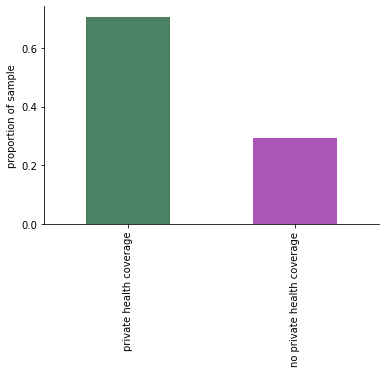

In [11]:
data_all[targetname] = data_all[targetname].replace({2:0})

colors = sns.diverging_palette(145, 300,s=60, n=2,as_cmap=False)

ax = data_all[targetname].value_counts(normalize=True).plot.bar(color=colors)
sns.despine()
plt.rc('font',size=15)
plt.ylabel('proportion of sample')
plt.xticks([0,1],['private health coverage','no private health coverage'])
plt.show()

figname = os.path.join(figdir,'prop_privatehealthinsurance.png')
fig = ax.get_figure()
fig.savefig(figname,dpi=1200,orientation='portrait', transparent=True,bbox_inches='tight')

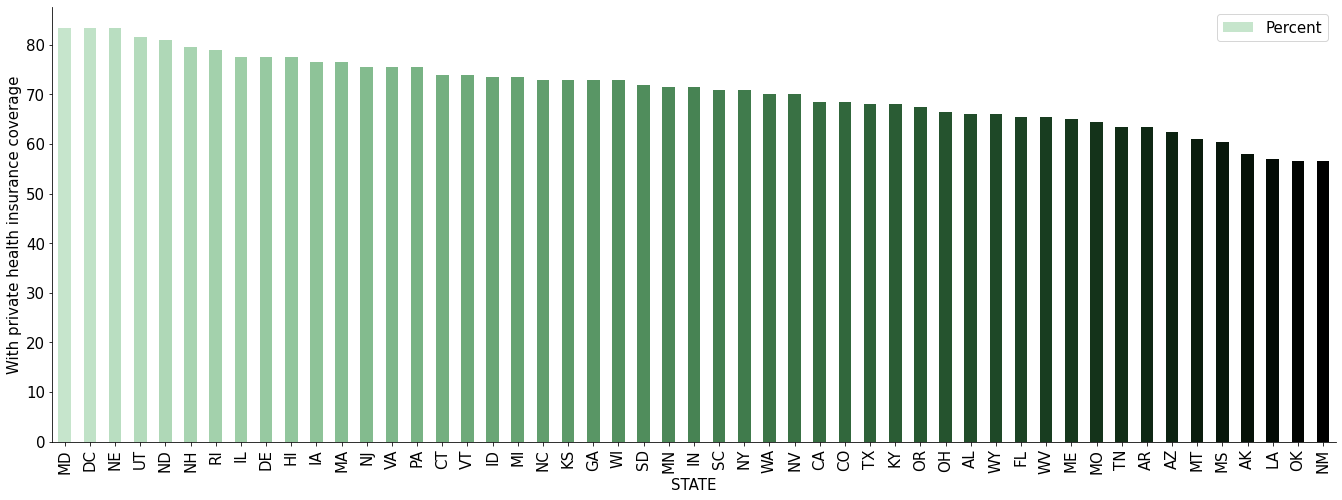

In [12]:
#plot percentage without by state
for check in targlabels.values():
    if check.__contains__('With private'):
        ylab = check
        
colors = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.85, n_colors = 51,reverse=False, as_cmap=False)

insdf  = data_all.groupby('STATE')[targetname].value_counts(normalize=True)
insdf  = insdf.mul(100).rename('Percent').reset_index()
ax = insdf[insdf[targetname] == 1][['STATE','Percent']].sort_values('Percent',ascending=False).plot.bar(color=colors,x='STATE',y='Percent',figsize=(23,8))
sns.despine()
plt.ylabel(ylab)
plt.show()

figname = os.path.join(figdir,'prop_privatehealthinsurance_bystate.png')
fig = ax.get_figure()
fig.savefig(figname,dpi=1200,orientation='portrait', transparent=True,bbox_inches='tight')

We can drop the other health insurance related columns because they are conceptually similar to our target variable.

In [13]:
for column in insurance_related:
    if column == targetname:
        continue
    else:
        data_all.drop(column,axis=1,inplace=True)

Now we can look to drop variables that have too many missing values.

In [14]:
missing_val = -1
thresh      = .33
for column in data_all:
    if any(data_all[column].isin([missing_val])):
        if data_all[column].isin([missing_val]).sum()/len(data_all[column]) > thresh:
            dets = utils.variableDetails(column)
            if dets['values']['item'][str(missing_val)].__contains__('N/A'):
                data_all.drop(column,axis=1,inplace=True)           

We also can check if most of the data in a column is the same, with very few records deviating.
If so, data may not be helpful/informative.

In [15]:
cnt = 0
thresh = 0.97
for column in data_all:
    prop = data_all[column].value_counts(normalize=True)
    if any(prop >= thresh):
        data_all.drop(column,axis=1,inplace=True) 

Lastly, we can check to see if any remaining columns have missing values

In [16]:
# check for other null or missing values
missing = pd.concat([data_all.isnull().sum(), 100 * data_all.isnull().mean()], axis=1)
missing.columns=['count', '%']
unqvals = missing['count'].unique()
if any(unqvals > 0):
    print('some missing values still')
else:
    print('no missing values')

no missing values


Save processed data to csv file

In [17]:
fname = os.path.join(interimdatadir,'allstates_subsample' + str(nsamples) + '.csv')
data_all.to_csv(fname)